In [6]:
import warnings
warnings.filterwarnings('ignore')

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#import pybinding as pb
import matplotlib.pyplot as plt
import numpy as np
import copy
import os
import re
import sys
from IPython.display import Math


from copy import deepcopy

from scipy.spatial import cKDTree
from math import pi, sqrt
#from pybinding.repository.graphene import a, a_cc, t
import pickle
import scipy.ndimage.filters

import matplotlib

from pylab import *

import matplotlib.gridspec as gridspec


def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    #MAX_HEIGHT_INCHES = 7.0
    #if fig_height > MAX_HEIGHT_INCHES:
    #    print("WARNING: fig_height too large:" + fig_height + 
    #          "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
    #    fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': [r'\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'font.size': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif',
              'figure.autolayout': True,
              'lines.linewidth' : 1.0
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):
    
    SPINE_COLOR = 'gray'

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax


In [7]:
aG = 2.46
acc = aG/np.sqrt(3.0)


def crossProduct(ourpoint, point1, point2):
    x1 = point1[0]
    y1 = point1[1]
    x2 = point2[0]
    y2 = point2[1]
    xA = ourpoint[0]
    yA = ourpoint[1]
    v1 = (x2-x1, y2-y1)   # Vector 1
    v2 = (x2-xA, y2-yA)   # Vector 1
    crossProd = v1[0]*v2[1] - v1[1]*v2[0] 
    return crossProd

def insideAAbis(ourpoint,rAAp,rAApp):
    A = np.array([rAAp,0])
    B = np.array([rAAp/2.0,rAApp])
    C = np.array([-rAAp/2.0,rAApp])
    D = np.array([-rAAp,0])
    E = np.array([-rAAp/2.0,-rAApp])
    F = np.array([rAAp/2.0,-rAApp])
    if np.logical_and(np.less_equal(crossProduct(ourpoint,A,B),0.0), np.less_equal(crossProduct(ourpoint,B,C),0.0)):
        if np.logical_and(np.less_equal(crossProduct(ourpoint,C,D),0.0), np.less_equal(crossProduct(ourpoint,D,E),0.0)):
            if np.logical_and(np.less_equal(crossProduct(ourpoint,E,F),0.0), np.less_equal(crossProduct(ourpoint,F,A),0.0)):
                return np.array([True])
            else:
                return np.array([False])
        else:
            return np.array([False])
    else:
        return np.array([False])
    
# def insideAAbis(ourpoint,rAAp,rAApp):
#     A = np.flip(np.array([rAAp,0]))
#     B = np.flip(np.array([rAAp/2.0,rAApp]))
#     C = np.flip(np.array([-rAAp/2.0,rAApp]))
#     D = np.flip(np.array([-rAAp,0]))
#     E = np.flip(np.array([-rAAp/2.0,-rAApp]))
#     F = np.flip(np.array([rAAp/2.0,-rAApp]))
#     if np.logical_and(np.less_equal(crossProduct(ourpoint,A,B),0.0), np.less_equal(crossProduct(ourpoint,B,C),0.0)):
#         if np.logical_and(np.less_equal(crossProduct(ourpoint,C,D),0.0), np.less_equal(crossProduct(ourpoint,D,E),0.0)):
#             if np.logical_and(np.less_equal(crossProduct(ourpoint,E,F),0.0), np.less_equal(crossProduct(ourpoint,F,A),0.0)):
#                 return np.array([True])
#             else:
#                 return np.array([False])
#         else:
#             return np.array([False])
#     else:
#         return np.array([False])
    
def insideABbis(ourpointO,rAAp,rAApp):
    #ourpoint = np.array([ourpoint[0] - aCC,ourpoint[1]])
    d1 = np.sqrt(acc**2 - (acc/2.0)**2)
    d2 = 3.0/4.0*acc
    A = np.array([rAAp,0])
    B = np.array([rAAp/2.0,rAApp])
    C = np.array([-rAAp/2.0,rAApp])
    D = np.array([-rAAp,0])
    E = np.array([-rAAp/2.0,-rAApp])
    F = np.array([rAAp/2.0,-rAApp])
    #ourpointVec = [np.array([ourpointO[0]- acc ,ourpointO[1]]),
    #                 np.array([ourpointO[0]+acc/2.0,ourpointO[1]+aG/2]),
    #                 np.array([ourpointO[0]+acc/2.0,ourpointO[1]-aG/2])]
    ourpointVec = [np.array([ourpointO[0] ,ourpointO[1]- acc]),
                     np.array([ourpointO[0]+aG/2,ourpointO[1]+acc/2.0]),
                     np.array([ourpointO[0]-aG/2,ourpointO[1]+acc/2.0])]
    for ourpoint in ourpointVec:
        if np.logical_and(np.less_equal(crossProduct(ourpoint,A,B),0.0), np.less_equal(crossProduct(ourpoint,B,C),0.0)):
            if np.logical_and(np.less_equal(crossProduct(ourpoint,C,D),0.0), np.less_equal(crossProduct(ourpoint,D,E),0.0)):
                if np.logical_and(np.less_equal(crossProduct(ourpoint,E,F),0.0), np.less_equal(crossProduct(ourpoint,F,A),0.0)):
                    status = np.array([True])
                    break
                else:
                    status = np.array([False])
            else:
                status = np.array([False])
        else:
            status = np.array([False])
            
    return status
    
    
def insideBAbis(ourpointO,rAAp,rAApp):
    #ourpoint = np.array([ourpoint[0] - aCC,ourpoint[1]])
    d1 = np.sqrt(acc**2 - (acc/2.0)**2)
    d2 = 3.0/4.0*acc
    A = np.array([rAAp,0])
    B = np.array([rAAp/2.0,rAApp])
    C = np.array([-rAAp/2.0,rAApp])
    D = np.array([-rAAp,0])
    E = np.array([-rAAp/2.0,-rAApp])
    F = np.array([rAAp/2.0,-rAApp])
    #ourpointVec = [np.array([ourpointO[0]+ acc ,ourpointO[1]]),
    #                 np.array([ourpointO[0]-acc/2.0,ourpointO[1]+aG/2]),
    #                 np.array([ourpointO[0]-acc/2.0,ourpointO[1]-aG/2])]
    ourpointVec = [np.array([ourpointO[0],ourpointO[1]+ acc ]),
                     np.array([ourpointO[0]+aG/2,ourpointO[1]-acc/2.0]),
                     np.array([ourpointO[0]-aG/2,ourpointO[1]-acc/2.0])]
    for ourpoint in ourpointVec:
        if np.logical_and(np.less_equal(crossProduct(ourpoint,A,B),0.0), np.less_equal(crossProduct(ourpoint,B,C),0.0)):
            if np.logical_and(np.less_equal(crossProduct(ourpoint,C,D),0.0), np.less_equal(crossProduct(ourpoint,D,E),0.0)):
                if np.logical_and(np.less_equal(crossProduct(ourpoint,E,F),0.0), np.less_equal(crossProduct(ourpoint,F,A),0.0)):
                    status = np.array([True])
                    break
                else:
                    status = np.array([False])
            else:
                status = np.array([False])
        else:
            status = np.array([False])
    
    return status
        
        
def insideSP1bis(ourpointO,rAA,w1,rAAp,rAApp):
    #ourpoint = np.array([ourpoint[0] - aCC,ourpoint[1]])
    A0 = np.array([rAA/2,0])
    B0 = np.array([rAAp/2.0,w1/2])
    C0 = np.array([-rAAp/2.0,w1/2])
    D0 = np.array([-rAA/2,0])
    E0 = np.array([-rAAp/2.0,-w1/2])
    F0 = np.array([rAAp/2.0,-w1/2])
    theta = -60*np.pi/180
    R = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    AR1 = np.matmul(R,A0)
    BR1 = np.matmul(R,B0)
    CR1 = np.matmul(R,C0)
    DR1 = np.matmul(R,D0)
    ER1 = np.matmul(R,E0)
    FR1 = np.matmul(R,F0)
    theta = 60*np.pi/180
    R = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    AR2 = np.matmul(R,A0)
    BR2 = np.matmul(R,B0)
    CR2 = np.matmul(R,C0)
    DR2 = np.matmul(R,D0)
    ER2 = np.matmul(R,E0)
    FR2 = np.matmul(R,F0)
    #ourpointVec = [np.array([ourpointO[0]- acc/2.0 ,ourpointO[1]]),
    #                 np.array([ourpointO[0]+acc/4.0,ourpointO[1]+aG/4]),
    #                 np.array([ourpointO[0]+acc/4.0,ourpointO[1]-aG/4])]
    ourpointVec = [np.array([ourpointO[0] ,ourpointO[1]- acc/2.0]),
                     np.array([ourpointO[0]+aG/4,ourpointO[1]+acc/4.0]),
                     np.array([ourpointO[0]-aG/4,ourpointO[1]+acc/4.0])]
    for ourpoint,pointvec in zip(ourpointVec, [[A0,B0,C0,D0,E0,F0],[AR1,BR1,CR1,DR1,ER1,FR1],[AR2,BR2,CR2,DR2,ER2,FR2]]):
        #A,B,C,D,E,F = pointvec
        A,B,C,D,E,F = pointvec
        if np.logical_and(np.less_equal(crossProduct(ourpoint,A,B),0.0), np.less_equal(crossProduct(ourpoint,B,C),0.0)):
            if np.logical_and(np.less_equal(crossProduct(ourpoint,C,D),0.0), np.less_equal(crossProduct(ourpoint,D,E),0.0)):
                if np.logical_and(np.less_equal(crossProduct(ourpoint,E,F),0.0), np.less_equal(crossProduct(ourpoint,F,A),0.0)):
                    status = np.array([True])
                    break
                else:
                    status = np.array([False])
            else:
                status = np.array([False])
        else:
            status = np.array([False])
            
    return status
        
def insideSP2bis(ourpointO,rAA,w1,rAAp,rAApp):
    A0 = np.array([rAA/2,0])
    B0 = np.array([rAAp/2.0,w1/2])
    C0 = np.array([-rAAp/2.0,w1/2])
    D0 = np.array([-rAA/2,0])
    E0 = np.array([-rAAp/2.0,-w1/2])
    F0 = np.array([rAAp/2.0,-w1/2])
    theta = 60*np.pi/180
    R = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    AR1 = np.matmul(R,A0)
    BR1 = np.matmul(R,B0)
    CR1 = np.matmul(R,C0)
    DR1 = np.matmul(R,D0)
    ER1 = np.matmul(R,E0)
    FR1 = np.matmul(R,F0)
    theta = -60*np.pi/180
    R = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    AR2 = np.matmul(R,A0)
    BR2 = np.matmul(R,B0)
    CR2 = np.matmul(R,C0)
    DR2 = np.matmul(R,D0)
    ER2 = np.matmul(R,E0)
    FR2 = np.matmul(R,F0)
    #ourpointVec = [np.array([ourpointO[0]- acc/2.0 ,ourpointO[1]]),
    #                 np.array([ourpointO[0]+acc/4.0,ourpointO[1]+aG/4]),
    #                 np.array([ourpointO[0]+acc/4.0,ourpointO[1]-aG/4])]
    ourpointVec = [np.array([ourpointO[0] ,ourpointO[1]+ acc/2.0]),
                     np.array([ourpointO[0]+aG/4,ourpointO[1]-acc/4.0]),
                     np.array([ourpointO[0]-aG/4,ourpointO[1]-acc/4.0])]
    for ourpoint,pointvec in zip(ourpointVec, [[A0,B0,C0,D0,E0,F0],[AR1,BR1,CR1,DR1,ER1,FR1],[AR2,BR2,CR2,DR2,ER2,FR2]]):
        #A,B,C,D,E,F = pointvec
        A,B,C,D,E,F = pointvec    
        if np.logical_and(np.less_equal(crossProduct(ourpoint,A,B),0.0), np.less_equal(crossProduct(ourpoint,B,C),0.0)):
            if np.logical_and(np.less_equal(crossProduct(ourpoint,C,D),0.0), np.less_equal(crossProduct(ourpoint,D,E),0.0)):
                if np.logical_and(np.less_equal(crossProduct(ourpoint,E,F),0.0), np.less_equal(crossProduct(ourpoint,F,A),0.0)):
                    status = np.array([True])
                    break
                else:
                    status = np.array([False])
            else:
                status = np.array([False])
        else:
            status = np.array([False])
            
    return status
        
def insideSP3bis(ourpointO,rAA,w1,rAAp,rAApp):
    #ourpoint = np.array([ourpoint[0] - aCC,ourpoint[1]])
    A0 = np.array([rAA/2,0])
    B0 = np.array([rAAp/2.0,w1/2])
    C0 = np.array([-rAAp/2.0,w1/2])
    D0 = np.array([-rAA/2,0])
    E0 = np.array([-rAAp/2.0,-w1/2])
    F0 = np.array([rAAp/2.0,-w1/2])
    theta = 60*np.pi/180
    R = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    AR1 = np.matmul(R,A0)
    BR1 = np.matmul(R,B0)
    CR1 = np.matmul(R,C0)
    DR1 = np.matmul(R,D0)
    ER1 = np.matmul(R,E0)
    FR1 = np.matmul(R,F0)
    theta = -60*np.pi/180
    R = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    AR2 = np.matmul(R,A0)
    BR2 = np.matmul(R,B0)
    CR2 = np.matmul(R,C0)
    DR2 = np.matmul(R,D0)
    ER2 = np.matmul(R,E0)
    FR2 = np.matmul(R,F0)
    theta = -180*np.pi/180

    
    ourpointVec = [np.array([ourpointO[0]-aG/2,ourpointO[1]]),
                   np.array([ourpointO[0]+aG/2,ourpointO[1]]),
                   np.array([ourpointO[0]-aG/4,ourpointO[1]-acc*3.0/4.0]),
                    np.array([ourpointO[0]+aG/4,ourpointO[1]+acc*3.0/4.0]),
                    np.array([ourpointO[0]+aG/4,ourpointO[1]-acc*3.0/4.0]),
                     np.array([ourpointO[0]-aG/4,ourpointO[1]+acc*3.0/4.0])]
    for ourpoint,pointvec in zip(ourpointVec, [[A0,B0,C0,D0,E0,F0],[A0,B0,C0,D0,E0,F0],
                                              [AR1,BR1,CR1,DR1,ER1,FR1],[AR1,BR1,CR1,DR1,ER1,FR1],
                                              [AR2,BR2,CR2,DR2,ER2,FR2],[AR2,BR2,CR2,DR2,ER2,FR2]]):
                                              #[AR3,BR3,CR3,DR3,ER3,FR3],[AR4,BR4,CR4,DR4,ER4,FR4],[AR5,BR5,CR5,DR5,ER5,FR5]]):
        A,B,C,D,E,F = pointvec 
    #A, B,C,D,E,F = A0,B0,C0,D0,E0,F0
    #ourpoint = ourpointVec[0]
    #for i in range(1):
        if np.logical_and(np.less_equal(crossProduct(ourpoint,A,B),0.0), np.less_equal(crossProduct(ourpoint,B,C),0.0)):
            if np.logical_and(np.less_equal(crossProduct(ourpoint,C,D),0.0), np.less_equal(crossProduct(ourpoint,D,E),0.0)):
                if np.logical_and(np.less_equal(crossProduct(ourpoint,E,F),0.0), np.less_equal(crossProduct(ourpoint,F,A),0.0)):
                    status = np.array([True])
                    break
                else:
                    status = np.array([False])
            else:
                status = np.array([False])
        else:
            status = np.array([False])
            
    return status




# Stacking profiles

In [8]:
os.chdir("/Users/nihao/Dropbox/Documents/Career/Calculs/newEncapsulatedMonolayer/commmensurateRelaxed/0.6/type1/")
data = np.genfromtxt("generate.xyz",skip_header=4)
dataI = np.genfromtxt("generateInit.xyz",skip_header=4)

xdata = data[:,1]
ydata = data[:,2]
zdata = data[:,3]

xdataI = dataI[:,1]
ydataI = dataI[:,2]
zdataI = dataI[:,3]

cutoff = 10000

xdataC = xdata[np.logical_and(xdata<cutoff, ydata<cutoff)]
ydataC = ydata[np.logical_and(xdata<cutoff, ydata<cutoff)]
zdataC = zdata[np.logical_and(xdata<cutoff, ydata<cutoff)]

xdataIC = xdataI[np.logical_and(xdata<cutoff, ydata<cutoff)]
ydataIC = ydataI[np.logical_and(xdata<cutoff, ydata<cutoff)]
zdataIC = zdataI[np.logical_and(xdata<cutoff, ydata<cutoff)]

xdataC_top = xdataC[zdataIC>18]
ydataC_top = ydataC[zdataIC>18]
zdataC_top = zdataC[zdataIC>18]

xdataIC_top = xdataIC[zdataIC>18]
ydataIC_top = ydataIC[zdataIC>18]
zdataIC_top = zdataIC[zdataIC>18]

xdataC_middle = xdataC[np.logical_and(zdataIC<18, zdataIC>14)]
ydataC_middle = ydataC[np.logical_and(zdataIC<18, zdataIC>14)]
zdataC_middle = zdataC[np.logical_and(zdataIC<18, zdataIC>14)]

xdataIC_middle = xdataIC[np.logical_and(zdataIC<18, zdataIC>14)]
ydataIC_middle = ydataIC[np.logical_and(zdataIC<18, zdataIC>14)]
zdataIC_middle = zdataIC[np.logical_and(zdataIC<18, zdataIC>14)]

xdataC_bottom = xdataC[zdataIC<14]
ydataC_bottom = ydataC[zdataIC<14]
zdataC_bottom = zdataC[zdataIC<14]

xdataIC_bottom = xdataIC[zdataIC<14]
ydataIC_bottom = ydataIC[zdataIC<14]
zdataIC_bottom = zdataIC[zdataIC<14]

topLayers = True # if one has 3 layers in the structure, chose only two layers to work on

if (topLayers):
    b_x = xdataC_middle
    b_y = ydataC_middle
    b_z = zdataC_middle
    
    t_x = xdataC_top
    t_y = ydataC_top
    t_z = zdataC_top
    
    b_xI = xdataIC_middle
    b_yI = ydataIC_middle
    b_zI = zdataIC_middle
    
    t_xI = xdataIC_top
    t_yI = ydataIC_top
    t_zI = zdataIC_top
else:
    b_x = xdataC_bottom
    b_y = ydataC_bottom
    b_z = zdataC_bottom
    
    t_x = xdataC_middle
    t_y = ydataC_middle
    t_z = zdataC_middle
    
    b_xI = xdataIC_bottom
    b_yI = ydataIC_bottom
    b_zI = zdataIC_bottom
    
    t_xI = xdataIC_middle
    t_yI = ydataIC_middle
    t_zI = zdataIC_middle


layerIndex = np.genfromtxt("layerIndex.dat")
sublattices = np.genfromtxt("sublattices.dat")[:,1]
    
    
print(len(xdataC_top),len(xdataC_middle),len(xdataC_bottom))
    
f = open("v","r") 
# connectivity vector, line 1 contains number of atoms for atom 1, 
# line 2 contains the indices for all the neighbors for atom 1, 
# line 3 contains number of atoms for atom 2, 
# line 4 contains indices of neighbors of atom 2, etc
# atom N has index N, need to use N-1 later on to match with Python
g = open("v2","w")
    
neighVec = []
    
i = 0
for line in f:
    a = line.split()
    i = i + 1
    if (i%2==0):
        g.write(line)
        neighVec.append(a)
        
print(len(neighVec))
            
    
            
f.close()
g.close()
    
if (topLayers):
    neighVecBN = np.asarray(neighVec)[zdataIC>18]
    sublatticesBN = sublattices[zdataIC>18]
else:
    neighVecBN = np.asarray(neighVec)[np.logical_and(zdataIC<18, zdataIC>14)]
    sublatticesBN = sublattices[np.logical_and(zdataIC<18, zdataIC>14)]


del_r = []
del_x = []
del_y = []
    
    #print(xdataBN)
    # iterate over all atoms in top layer
for x1, y1, z1, x1I, y1I, z1I, neigh, SL in zip(t_x,t_y,t_z,t_xI,t_yI,t_zI,neighVecBN, sublatticesBN):
    diffMin = 100
    dxMin = 100
    dyMin = 100
    for el in neigh:
        x2I = xdataIC[int(el)-1]
        y2I = ydataIC[int(el)-1]
        z2I = zdataIC[int(el)-1]
        x2 = xdataC[int(el)-1]
        y2 = ydataC[int(el)-1]
        z2 = zdataC[int(el)-1]
        #print(int(neigh[0]),x1,x2)
        #diff1 = np.sqrt((x2-x1)**2 + (y2-y1)**2)
        diff1 = np.sqrt((x2-x1)**2 + (y2-y1)**2)# + (z2I-z1I)**2)
        #dx = x2-x1
        if (topLayers):
            if (diff1 < diffMin and layerIndex[int(el)-1] == 2 and SL == (sublattices[int(el)-1]+2)):
                diffMin = diff1
                dxMin = x2-x1
                dyMin = y2-y1
        else:
            if (diff1 < diffMin and layerIndex[int(el)-1] == 1 and SL == (sublattices[int(el)-1]+2)):
                diffMin = diff1
                dxMin = x2-x1
                dyMin = y2-y1

    del_r.append(diffMin)
    del_x.append(dxMin)
    del_y.append(dyMin)

cutoffbis = 10000

with open('displacementsCarrFormat.txt', 'w') as f1:
    for x, y, z, disp, dxVal, dyVal  in zip(t_x, t_y, t_z, del_r, del_x, del_y):#, dzTop):
        if (x<cutoffbis and y<cutoffbis):
            f1.write(str(x) + "   " + str(y) + "   " + str(z) + "  " + str(disp)  + "   " + str(dxVal) + "   " + str(dyVal) +"\n")

4538 4704 4538
13780


1.4202816622064793
[ 16 342 405 857 189 216 244]
ratioAA 0.1507271925958572
ratioAB 0.17849272807404143
ratioBA 0.377699427060379
ratioSP1 0.08329660643455267
ratioSP2 0.09519612163948876
ratioNA 0.007051564565888057
[[0.                nan        nan ...        nan        nan        nan]
 [       nan 0.02679911 0.0261639  ...        nan        nan        nan]
 [       nan 0.0142381  0.05359822 ...        nan        nan        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]


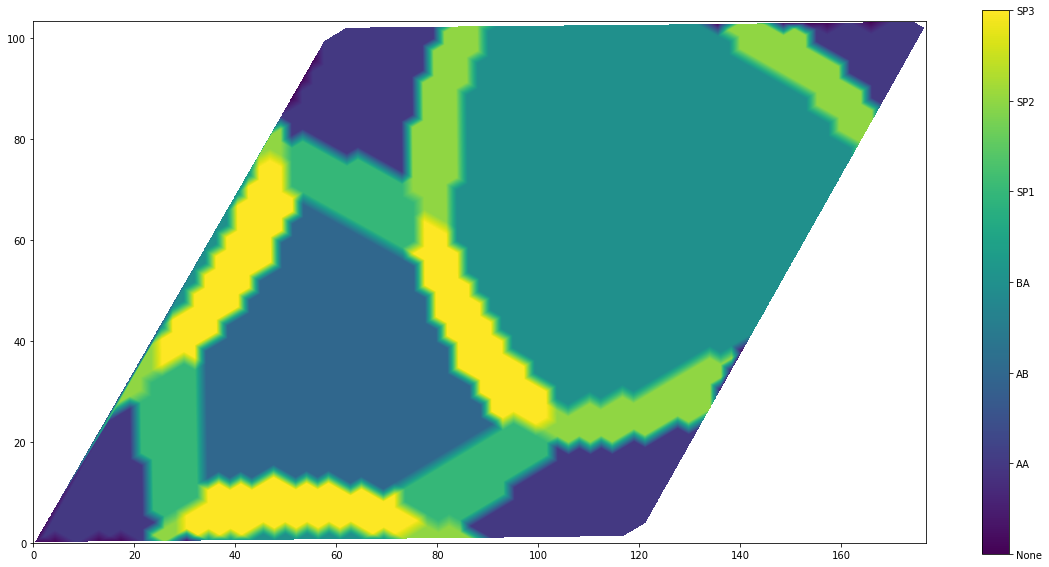

In [9]:
thetaRAAVec = []
ratioVec = []
ratioVecSP = []

print(acc)

Factor = 6
#FF = 1
rAA = 2*acc*np.sqrt(1/12)
w1 = acc/Factor
rAApp = (acc-w1)/2.0
rAAp = 2/np.sqrt(3)*rAApp
w2 = acc-2*rAApp
w3 = acc-2*rAApp

data = np.genfromtxt("displacementsCarrFormat.txt")#, dtype=(np.str, np.float, np.float, np.float))

xdata = data[:,0][::2]
ydata = data[:,1][::2]
zdataDX = data[:,4][::2]
zdataDY = data[:,5][::2]

Surface = [1 if insideAAbis(np.array([dx,dy]),rAAp,rAApp)
             else 2 if insideABbis(np.array([dx,dy]),rAAp,rAApp)
             else 3 if insideBAbis(np.array([dx,dy]),rAAp,rAApp) 
             #else 0 if np.logical_and(np.logical_and(insideSP3(np.array([dx,dy]),w3),insideSP2(np.array([dx,dy]),w2)),insideSP1(np.array([dx,dy]),w1))
             else 4 if insideSP1bis(np.array([dx,dy]),rAA,w1,rAAp,rAApp)
             else 5 if insideSP2bis(np.array([dx,dy]),rAA,w1,rAAp,rAApp)
             else 6 if insideSP3bis(np.array([dx,dy]),rAA,w1,rAAp,rAApp)
             else 0
             for dx,dy in zip(zdataDY,zdataDX)] # Changed role of dx and dy here to match the conventions from sketch with the ones coming out of code

count_arr = np.bincount(Surface)
print(count_arr)
ratioAA = count_arr[1]/len(Surface)
ratioAB = count_arr[2]/len(Surface)
ratioBA = count_arr[3]/len(Surface)
ratioSP1 = count_arr[4]/len(Surface)
ratioSP2 = count_arr[5]/len(Surface)
ratioSP3 = count_arr[6]/len(Surface)
ratioNA = count_arr[0]/len(Surface)
print("ratioAA", ratioAA)
print("ratioAB", ratioAB)
print("ratioBA", ratioBA)
print("ratioSP1", ratioSP1)
print("ratioSP2", ratioSP2)
print("ratioNA", ratioNA)


plt.figure(figsize=(20,10))
#plt.scatter(xdata,ydata,c=Surface)
# plt.gca().set_aspect("equal")
# #print (Surface)

num = 3000
x = np.linspace(min(xdata),max(xdata),num)
y = np.linspace(min(ydata),max(ydata),num)
#
from scipy.interpolate import griddata
SurfaceIntRebo=griddata((xdata,ydata),Surface,(x[None,:], y[:,None]), method='linear')
print (SurfaceIntRebo)
np.savetxt('Sur',SurfaceIntRebo)
plt.imshow(SurfaceIntRebo,origin="lower",vmin = 0,vmax = 6,extent=[min(xdata),max(xdata),min(ydata),max(ydata)])#,cmap="tab10")
cbar = plt.colorbar()
cbar.set_ticks([0, 1, 2, 3, 4, 5, 6])
cbar.set_ticklabels(["None","AA", "AB", "BA", "SP1", "SP2", "SP3"])


SurfaceIntReboTopAA = SurfaceIntRebo
SurfaceTopAA = Surface